In [100]:
import numpy as np
import datetime as dt
from tqdm import tqdm

In [1]:
with open('/home/hxssg1124/Developer/zn.txt') as f:
    lines = f.readlines()

In [10]:
prices = []
for e in lines:
    if not e.strip():
        continue
    prices.append(float(e.split('\t')[1].strip()))

In [24]:
dates = []
for e in lines:
    if not e.strip():
        continue
    dates.append(e.split('\t')[0].strip())
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]

In [13]:
diff_prices = [prices[i] / prices[i-1] - 1 for i in range(1, len(prices))]

In [42]:
mean_diff_prices = []
for i in range(200, len(diff_prices)):
    mean_diff_prices.append(np.mean(diff_prices[i-200:i]))

In [45]:
moving_avg_price = []
for i in range(200, len(prices)):
    moving_avg_price.append(np.mean(prices[i-200:i]))

In [43]:
print(np.mean(diff_prices[-200:]))

0.0002924632669907318


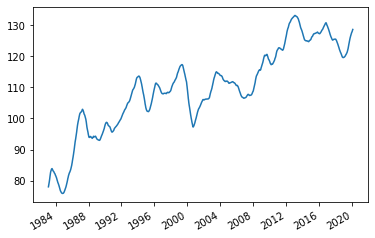

In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.plot(dates[200:], moving_avg_price)
plt.gcf().autofmt_xdate()
plt.show()

In [49]:
import torch
import torch.nn as nn
import numpy as np

In [62]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = torch.tensor(input_data[i:i+tw]).cuda()
        train_label = torch.tensor(input_data[i+tw:i+tw+1]).cuda()
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [139]:
train_inout_seq = create_inout_sequences(moving_avg_price[:-1000], 10)
test_inout_seq = create_inout_sequences(moving_avg_price[-1000:], 10)

In [140]:
train_inout_seq[0], test_inout_seq[0]

((tensor([77.9961, 78.0570, 78.1184, 78.1825, 78.2445, 78.3027, 78.3620, 78.4245,
          78.4863, 78.5506], device='cuda:0'),
  tensor([78.6124], device='cuda:0')),
 (tensor([127.4388, 127.4543, 127.4764, 127.4938, 127.5118, 127.5228, 127.5294,
          127.5401, 127.5504, 127.5587], device='cuda:0'),
  tensor([127.5676], device='cuda:0')))

In [141]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=512, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).cuda()

        self.linear = nn.Linear(hidden_layer_size, output_size).cuda()

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).cuda(),
                            torch.zeros(1,1,self.hidden_layer_size).cuda())

    def forward(self, input_seq):
        input_seq = input_seq.view(len(input_seq) ,1, -1)
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [145]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [146]:
print(model)

LSTM(
  (lstm): LSTM(1, 512)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)


In [160]:
epochs = 150

for i in range(epochs):
    total_train_loss = 0
    total_test_loss = 0
    for seq, labels in tqdm(train_inout_seq):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
                        torch.zeros(1, 1, model.hidden_layer_size).cuda())

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        total_train_loss += single_loss.item()
        optimizer.step()
        
    with torch.no_grad():
        for seq, labels in tqdm(test_inout_seq):
            y_pred = model(seq)
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
                    torch.zeros(1, 1, model.hidden_layer_size).cuda())

            single_loss = loss_function(y_pred, labels)
            total_test_loss += single_loss.item()

    #if i%25 == 1:
    total_train_loss /= len(train_inout_seq)
    total_test_loss /= len(test_inout_seq)
    print(f'epoch: {i:3} train loss: {total_train_loss:10.8f}')
    print(f'epoch: {i:3} test loss: {total_test_loss:10.8f}')

#print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

  1%|          | 59/8299 [00:00<00:14, 582.37it/s]

epoch:   0 train loss: 0.10803326
epoch:   0 test loss: 8.22205669


  1%|          | 57/8299 [00:00<00:14, 567.82it/s]

epoch:   1 train loss: 0.38102087
epoch:   1 test loss: 15.54212023


 24%|██▍       | 2002/8299 [00:03<00:10, 605.18it/s]


KeyboardInterrupt: 

In [170]:
total_test_loss = 0
y_preds = []
with torch.no_grad():
    for seq, labels in tqdm(test_inout_seq):
        y_pred = model(seq)
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
                    torch.zeros(1, 1, model.hidden_layer_size).cuda())
        y_preds.append(y_pred.item())

        single_loss = loss_function(y_pred, labels)
        total_test_loss += single_loss.item()
print(total_test_loss / len(test_inout_seq))

100%|██████████| 990/990 [00:00<00:00, 2314.53it/s]

118.93718590784555


990
990


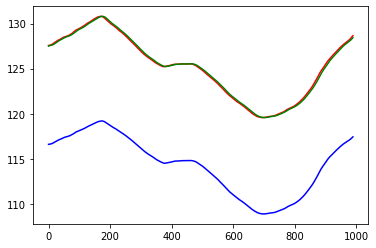

In [175]:
labels = [e[1].item() for e in test_inout_seq]
mean_test = [torch.mean(e[0]) for e in test_inout_seq]
print(len(test_inout_seq))
print(len(y_preds))
plt.plot(labels, 'r')
plt.plot(y_preds, 'b')
plt.plot(mean_test, 'g')
plt.show()